In [1]:
import xarray as xr
import numpy as np
import os
import arrow
import pandas as pd
import metpy.calc as mpcalc
from metpy.units import units
import glob
import re

In [2]:
station_file_list = ['59754.20130101-20221031.csv','59757.20130101-20221031.csv', '59758.20130101-20221031.csv']
if os.environ['COMPUTERNAME'] == 'DESKTOP-EQAO3M5':
  computer_flag = 'home'
else:
  computer_flag = 'office'

if computer_flag == 'home':
  root_dir = "F:/github/pythonScript/seafog/"
else:
  root_dir = "H:/github/python/seafog/"


In [3]:
file_59754 = os.path.normpath(os.path.join(root_dir, f'./data/station/{station_file_list[0]}'))
file_59757 = os.path.normpath(os.path.join(root_dir, f'./data/station/{station_file_list[1]}'))
file_59758 = os.path.normpath(os.path.join(root_dir, f'./data/station/{station_file_list[2]}'))
df_59754 = pd.read_csv(file_59754,sep=',',na_values=[9999])
df_59757 = pd.read_csv(file_59757,sep=',',na_values=[9999])
df_59758 = pd.read_csv(file_59758,sep=',',na_values=[9999])

C:\Users\Henry\AppData\Local\Temp\ipykernel_2320\1673744826.py:4: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  df_59754 = pd.read_csv(file_59754,sep=',',na_values=[9999])
C:\Users\Henry\AppData\Local\Temp\ipykernel_2320\1673744826.py:5: DtypeWarning: Columns (12,112) have mixed types. Specify dtype option on import or set low_memory=False.
  df_59757 = pd.read_csv(file_59757,sep=',',na_values=[9999])
C:\Users\Henry\AppData\Local\Temp\ipykernel_2320\1673744826.py:6: DtypeWarning: Columns (112) have mixed types. Specify dtype option on import or set low_memory=False.
  df_59758 = pd.read_csv(file_59758,sep=',',na_values=[9999])


In [4]:
df_59754["DDATETIME"] = pd.to_datetime(df_59754["DDATETIME"])
df_59754.index = df_59754["DDATETIME"]

df_59757["DDATETIME"] = pd.to_datetime(df_59757["DDATETIME"])
df_59757.index = df_59757["DDATETIME"]

df_59758["DDATETIME"] = pd.to_datetime(df_59758["DDATETIME"])
df_59758.index = df_59758["DDATETIME"]

df_59754
outerDate = pd.concat([df_59754["DDATETIME"], df_59757["DDATETIME"], df_59758["DDATETIME"]], ignore_index=True)
outerDate = outerDate.drop_duplicates()

In [5]:
outerDate = outerDate.reset_index(drop=True)
df_out = pd.DataFrame(outerDate)

In [6]:
vis = np.full_like(outerDate, np.nan, dtype=np.float32)
rain01 = np.full_like(outerDate, np.nan, dtype=np.float32)# 过去一小时降水
rh =  np.full_like(outerDate, np.nan, dtype=np.float32) # 相对湿度


In [7]:
for index in  range(len(vis)):
    iTime = outerDate.iloc[index]
    df_list = [df_59754, df_59757, df_59758]
    for i_df in df_list:
        if iTime in i_df.index:
            if np.isnan(vis[index]) or (vis[index] > i_df.loc[iTime]['V20059']):
                vis[index] = i_df.loc[iTime]['V20059']
                rain01[index] = i_df.loc[iTime]['V13019']
                rh[index] = i_df.loc[iTime]['V13003']

## 取最小能见度

In [ ]:
outerDate.iloc[83982]

In [8]:
df_out['V20059'] = vis
df_out['V13019'] = rain01
df_out['V13003'] = rh

In [9]:

df_out.loc[(df_out['V20059']<=1000.0) & (df_out['V13003']<=90.0),('V20059')] = np.nan # 去掉相对湿度90%的低能见度事件
df_out.dropna(subset=['V20059'], inplace=True)
df_out.sort_values(by=['DDATETIME'], inplace=True)
df_out.index = df_out['DDATETIME'].values

In [10]:
print(df_out)

                              DDATETIME   V20059  V13019  V13003
2013-01-31 04:00:00 2013-01-31 04:00:00  12756.0     0.0    70.0
2013-01-31 05:00:00 2013-01-31 05:00:00  22272.0     0.0    64.0
2013-01-31 06:00:00 2013-01-31 06:00:00  24547.0     0.0    66.0
2013-01-31 07:00:00 2013-01-31 07:00:00  15263.0     0.0    66.0
2013-01-31 08:00:00 2013-01-31 08:00:00  18838.0     0.0    74.0
...                                 ...      ...     ...     ...
2022-10-29 20:00:00 2022-10-29 20:00:00   6622.0     0.0    83.0
2022-10-29 21:00:00 2022-10-29 21:00:00   9435.0     0.0    84.0
2022-10-29 22:00:00 2022-10-29 22:00:00   9630.0     0.0    78.0
2022-10-29 23:00:00 2022-10-29 23:00:00  16545.0     0.0    78.0
2022-10-30 00:00:00 2022-10-30 00:00:00  17840.0     0.0    76.0

[83381 rows x 4 columns]


<AxesSubplot:>

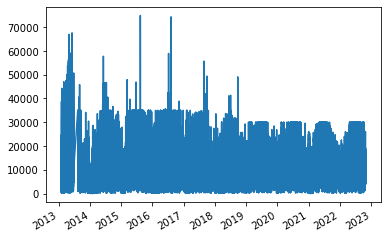

In [11]:
df_out['V20059'].plot()

In [12]:
fog = df_out['V20059']<1000
fog.value_counts()

False    81532
True      1849
Name: V20059, dtype: int64

In [13]:
fog = df_59754['V20059']<1000
fog.value_counts()

False    82607
True      1375
Name: V20059, dtype: int64

In [ ]:
df_out.to_csv('all_stations_v2.csv')